In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, roc_auc_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load the Iris dataset from CSV
iris_df = pd.read_csv('iris.csv')

X = iris_df.iloc[:, :-1].values
y = iris_df.iloc[:, -1].values
# Convert string labels to numeric
label_mapping = {label: idx for idx, label in enumerate(np.unique(y))}
y = np.array([label_mapping[label] for label in y])

# Split the dataset into features (X) and target (y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [3]:
# Create a custom Dataset
class IrisDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create DataLoaders
train_dataset = IrisDataset(X_train, y_train)
test_dataset = IrisDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [4]:
# Define the neural network model
class IrisNet(nn.Module):
    def __init__(self, input_size):
        super(IrisNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
# Initialize the model, loss function, and optimizer
input_size = X_train.shape[1]  # Number of features
model = IrisNet(input_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_losses.append(val_loss / len(test_loader))

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')


Epoch [10/100], Train Loss: 0.6399, Val Loss: 0.5931
Epoch [20/100], Train Loss: 0.3355, Val Loss: 0.2685
Epoch [30/100], Train Loss: 0.1909, Val Loss: 0.1414
Epoch [40/100], Train Loss: 0.1172, Val Loss: 0.0796
Epoch [50/100], Train Loss: 0.0841, Val Loss: 0.0547
Epoch [60/100], Train Loss: 0.0685, Val Loss: 0.0437
Epoch [70/100], Train Loss: 0.0639, Val Loss: 0.0365
Epoch [80/100], Train Loss: 0.0544, Val Loss: 0.0338
Epoch [90/100], Train Loss: 0.0504, Val Loss: 0.0306
Epoch [100/100], Train Loss: 0.0476, Val Loss: 0.0274


In [8]:
model.eval()
y_true = []
y_pred = []
y_pred_proba = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _,predicted = torch.max(outputs, 1)
        probabilities = torch.softmax(outputs, dim=1)

        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())
        y_pred_proba.extend(probabilities.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)
precision, recall, f1,_  = precision_recall_fscore_support(y_true, y_pred, average='weighted')

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_true, y_pred_proba, multi_class='ovr')

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
ROC-AUC: 1.0000
Confusion Matrix:
[[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]


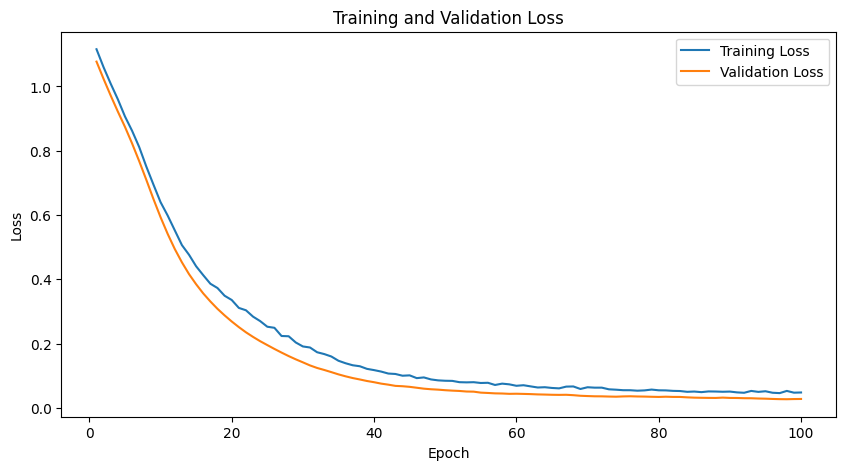

In [10]:
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')
print('Confusion Matrix:')
print(conf_matrix)

# Visualize the loss during the model training process
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

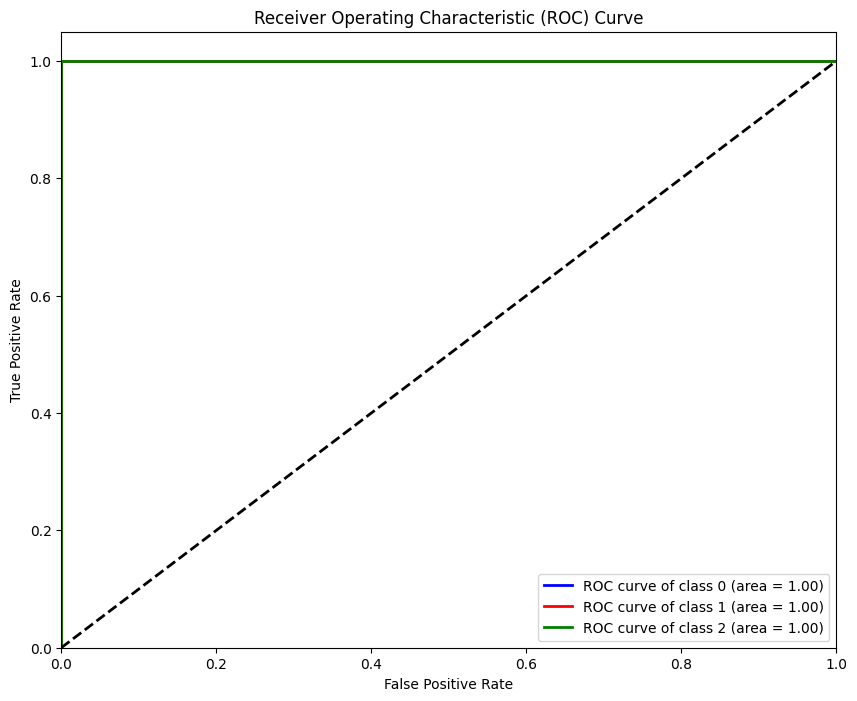

In [11]:
# Plot ROC curves for each class
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()